# MVP and HRP Portfolio Design for Media Sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [2]:
# load dataset
dataset = read_csv('media.csv',index_col=0)

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [5]:
# shape
dataset.shape

(1482, 10)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.head()

ZEEL.NS      PVR.NS    SUNTV.NS  SAREGAMA.NS  TV18BRDCST.NS  INOXLEISUR.NS  \
2016-01-01  432.899994  794.950012  430.950012    36.584999      47.799999     239.399994   
2016-01-04  421.950012  806.750000  421.200012    35.520000      46.099998     235.899994   
2016-01-05  425.049988  824.150024  425.950012    35.660000      46.450001     236.600006   
2016-01-06  423.149994  817.150024  421.700012    34.974998      47.000000     235.149994   
2016-01-07  415.399994  795.950012  409.750000    33.305000      43.750000     233.300003   

             DISHTV.NS  NETWORK18.NS  NAZARA.NS  HATHWAY.NS  
2016-01-01  102.150002     59.000000        NaN   44.549999  
2016-01-04  100.550003     58.349998        NaN   43.200001  
2016-01-05  100.099998     57.150002        NaN   44.000000  
2016-01-06  103.750000     57.400002        NaN   43.700001  
2016-01-07   97.849998     54.849998        NaN   42.250000

<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [7]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1482, 10)

Getting rid of the columns with more than 30% missing values. 

In [8]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1482, 9)

Given that there are null values drop the rown contianing the null values.

In [9]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

ZEEL.NS      PVR.NS    SUNTV.NS  SAREGAMA.NS  TV18BRDCST.NS  INOXLEISUR.NS  \
2016-01-01  432.899994  794.950012  430.950012    36.584999      47.799999     239.399994   
2016-01-04  421.950012  806.750000  421.200012    35.520000      46.099998     235.899994   
2016-01-05  425.049988  824.150024  425.950012    35.660000      46.450001     236.600006   
2016-01-06  423.149994  817.150024  421.700012    34.974998      47.000000     235.149994   
2016-01-07  415.399994  795.950012  409.750000    33.305000      43.750000     233.300003   

             DISHTV.NS  NETWORK18.NS  HATHWAY.NS  
2016-01-01  102.150002     59.000000   44.549999  
2016-01-04  100.550003     58.349998   43.200001  
2016-01-05  100.099998     57.150002   44.000000  
2016-01-06  103.750000     57.400002   43.700001  
2016-01-07   97.849998     54.849998   42.250000

<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.30% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [10]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8330)

In [11]:
X_train = X.head(train_len)

In [12]:
X_train

ZEEL.NS       PVR.NS    SUNTV.NS  SAREGAMA.NS  TV18BRDCST.NS  INOXLEISUR.NS  \
2016-01-01  432.899994   794.950012  430.950012    36.584999      47.799999     239.399994   
2016-01-04  421.950012   806.750000  421.200012    35.520000      46.099998     235.899994   
2016-01-05  425.049988   824.150024  425.950012    35.660000      46.450001     236.600006   
2016-01-06  423.149994   817.150024  421.700012    34.974998      47.000000     235.149994   
2016-01-07  415.399994   795.950012  409.750000    33.305000      43.750000     233.300003   
...                ...          ...         ...          ...            ...            ...   
2020-12-24  217.300003  1279.800049  484.450012    74.089996      31.150000     278.049988   
2020-12-28  220.149994  1310.400024  490.649994    80.730003      31.500000     282.799988   
2020-12-29  218.149994  1298.000000  485.649994    81.385002      31.049999     281.000000   
2020-12-30  219.149994  1290.000000  480.500000    81.480003      31.049999     280.750000   
2020-12-31  223.500000  1320.199951  480.750000    83.544998      30.900000     282.299988   

             DISHTV.NS  NETWORK18.NS  HATHWAY.NS  
2016-01-01  102.150002     59.000000   44.549999  
2016-01-04  100.550003     58.349998   43.200001  
2016-01-05  100.099998     57.150002   44.000000  
2016-01-06  103.750000     57.400002   43.700001  
2016-01-07   97.849998     54.849998   42.250000  
...                ...           ...         ...  
2020-12-24   14.750000     36.650002   33.700001  
2020-12-28   13.900000     36.599998   33.299999  
2020-12-29   12.850000     36.150002   32.799999  
2020-12-30   13.350000     36.150002   32.700001  
2020-12-31   13.400000     35.900002   33.150002  

[1234 rows x 9 columns]

In [13]:
X_test = X.tail(row-train_len)

In [14]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [15]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [16]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([4.       , 7.       , 0.5748711, 2.       ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

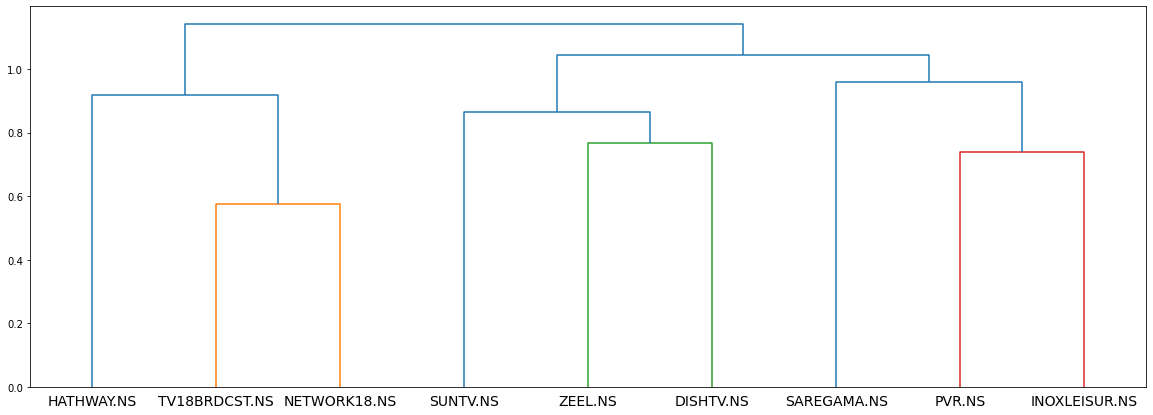

In [17]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [18]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [19]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [20]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [21]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [22]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                    MVP       HRP
ZEEL.NS        0.125641  0.106956
PVR.NS         0.226806  0.189097
SUNTV.NS       0.147017  0.144413
SAREGAMA.NS    0.102243  0.098220
TV18BRDCST.NS  0.010179  0.062432
INOXLEISUR.NS  0.163324  0.179198
DISHTV.NS      0.026929  0.067699
NETWORK18.NS   0.117804  0.068980
HATHWAY.NS     0.080058  0.083005


Text(0.5, 1.0, 'HRP')

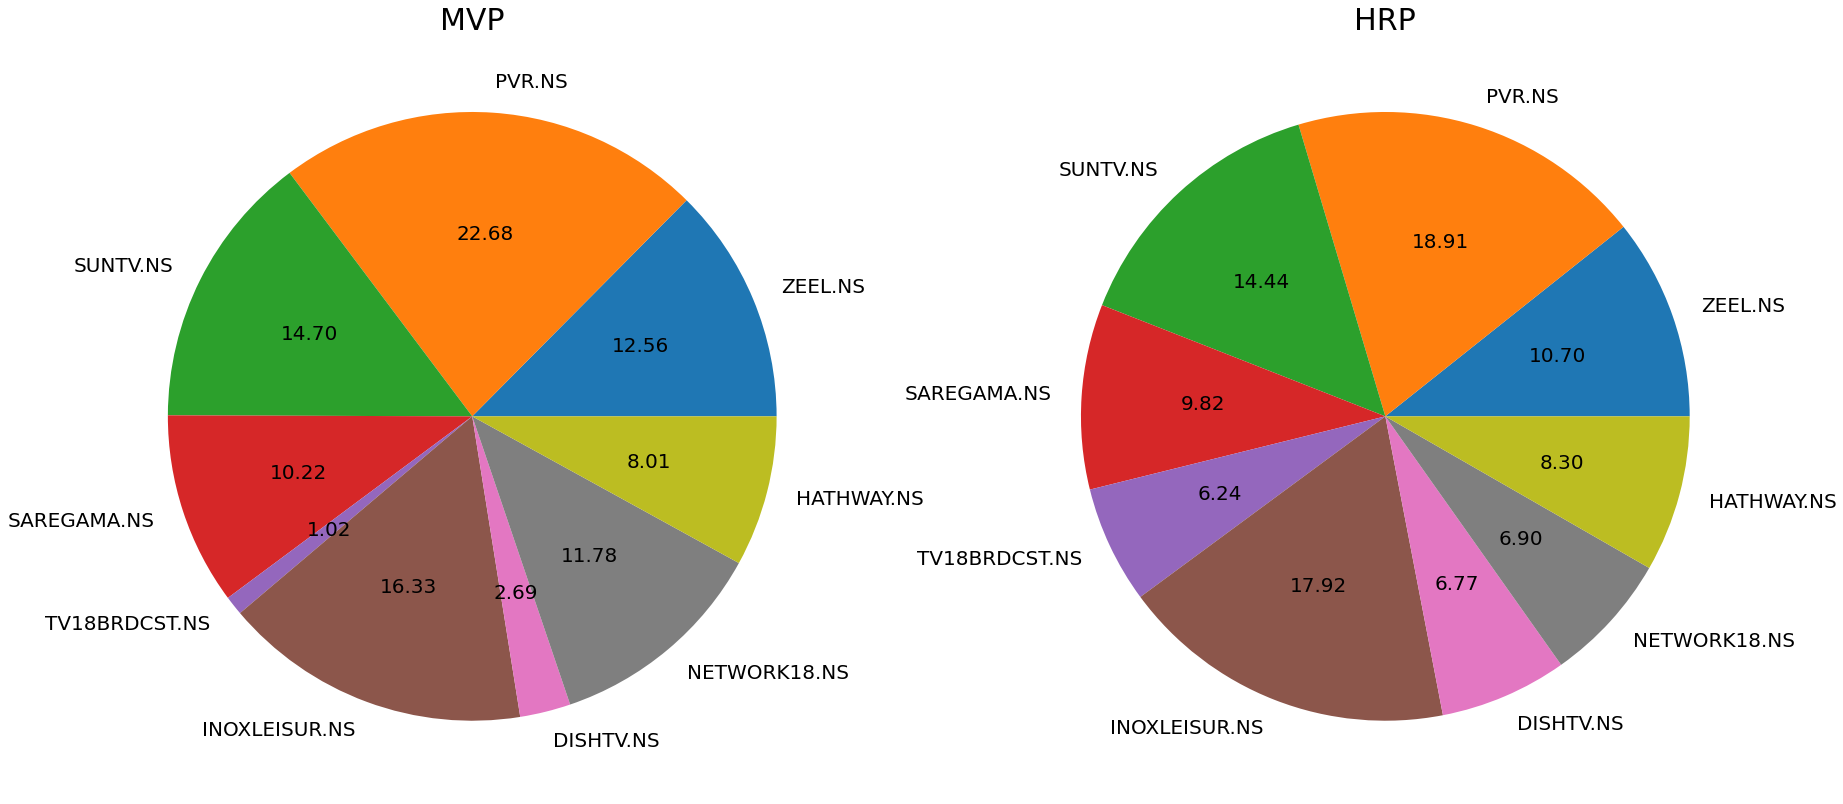

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [24]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

ZEEL.NS          0.125641
PVR.NS           0.226806
SUNTV.NS         0.147017
SAREGAMA.NS      0.102243
TV18BRDCST.NS    0.010179
INOXLEISUR.NS    0.163324
DISHTV.NS        0.026929
NETWORK18.NS     0.117804
HATHWAY.NS       0.080058
Name: MVP, dtype: float64

In [25]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

ZEEL.NS          0.106956
PVR.NS           0.189097
SUNTV.NS         0.144413
SAREGAMA.NS      0.098220
TV18BRDCST.NS    0.062432
INOXLEISUR.NS    0.179198
DISHTV.NS        0.067699
NETWORK18.NS     0.068980
HATHWAY.NS       0.083005
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios 

### 5.1 Cumulative Returns - Training and Test Data 

In [26]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:ylabel='Return'>

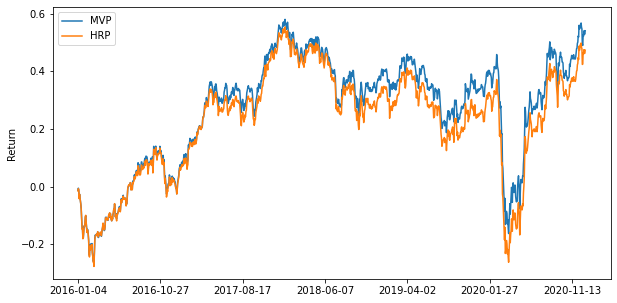

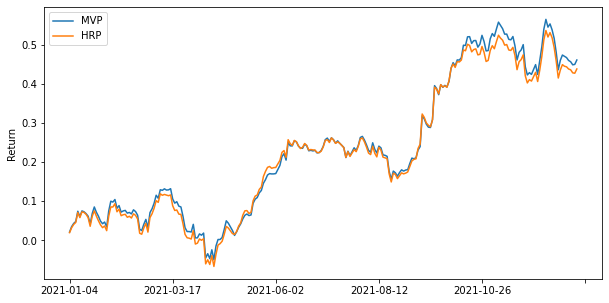

In [27]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [28]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.110425
HRP    0.096632
dtype: float64

In [29]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.470359
HRP    0.446960
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [30]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.262999     0.419867
HRP  0.265802     0.363547

In [31]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.285525         1.647349
HRP   0.278096         1.607217